Create the Service Account in your GCP project.
Generate a JSON key file. 

In [1]:
GCP_PROJECT_NAME='ob-google-analytics'
SERVICE_ACCOUNT_NAME='ob-google-analytics-sa'
SERVICE_ACCOUNT_ID='ob-google-analytics-sa'
SERVICE_ACCOUNT_EMAIL_ADDR='ob-google-analytics-sa@valued-vault-419517.iam.gserviceaccount.com'

# https://developers.google.com/analytics/devguides/reporting/data/v1/api-schema#metrics
GA_METRICS = [
    'activeUsers', 
    # 'active7DayUsers',
    # 'active28DayUsers',
    # 'newUsers',
    'averageSessionDuration',
    # 'engagedSessions',
    'engagementRate',
    'bounceRate',
    'sessions', 
    # 'sessionsPerUser',
    # 'organicGoogleSearchClicks',
    # 'dauPerWau',
    # 'dauPerMau',
    # 'wauPerMau',
]
 
# https://developers.google.com/analytics/devguides/reporting/data/v1/api-schema#dimensions
GA_DIMENSIONS = [
    # 'audienceId',
    'browser',
    'city',
    'region',
    'country',
    # 'contentId',
    'dateHourMinute',
    # 'dayOfWeekName',
    'deviceCategory',
    # 'deviceModel',
    'eventName',
    'fullPageUrl',
    # 'googleAdsKeyword',
    # 'googleAdsQuery',
    'landingPage',
    # 'language',
    # 'mobileDeviceBranding',
    # 'mobileDeviceMarketingName',
    # 'mobileDeviceModel',
    # 'operatingSystemWithVersion',
    # 'pageTitle',
    # 'region',
    # 'searchTerm',
    # 'userAgeBracket',
    # 'userGender'
]

GA_START_DATE, GA_END_DATE = '2daysAgo', 'yesterday'
GA_KEY_FILE_LOCATION = 'credentials.json'
GA_SCOPES = ['https://www.googleapis.com/auth/analytics.readonly']
GA_PROPERTY_ID = "300797527"

GA_REQUEST_LIMIT = 100_000

## Make the API calls

https://developers.google.com/analytics/devguides/reporting/data/v1

In [2]:
from google.analytics.data_v1beta.types import DateRange, Dimension, Metric, RunReportRequest
from google.analytics.data_v1beta import BetaAnalyticsDataClient

from tqdm.notebook import tqdm
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

In [3]:
%env GOOGLE_APPLICATION_CREDENTIALS=/Users/eddie/Dev/dbt-snowflake-metaflow/notebooks/credentials.json

env: GOOGLE_APPLICATION_CREDENTIALS=/Users/eddie/Dev/dbt-snowflake-metaflow/notebooks/credentials.json


In [4]:
client = BetaAnalyticsDataClient()

In [5]:
request = RunReportRequest(
    property=f"properties/{GA_PROPERTY_ID}",
    dimensions=[Dimension(name=dimension_name) for dimension_name in GA_DIMENSIONS],
    metrics=[Metric(name=metric_name) for metric_name in GA_METRICS],
    date_ranges=[DateRange(start_date=GA_START_DATE, end_date=GA_END_DATE)],
    limit=GA_REQUEST_LIMIT,
)
response = client.run_report(request)

In [6]:
row_id = 75
d = dict(zip(GA_DIMENSIONS, [v.value for v in response.rows[row_id].dimension_values])) 
d |= dict(zip(GA_METRICS, [v.value for v in response.rows[row_id].metric_values]))
d

{'browser': 'Chrome',
 'city': 'Dublin',
 'region': 'County Dublin',
 'country': 'Ireland',
 'dateHourMinute': '202404080910',
 'deviceCategory': 'desktop',
 'eventName': 'first_visit',
 'fullPageUrl': 'outerbounds.com/get-started/',
 'landingPage': '/get-started',
 'activeUsers': '2',
 'averageSessionDuration': '0',
 'engagementRate': '0',
 'bounceRate': '1',
 'sessions': '2'}

In [7]:
data = []
for row in tqdm(response.rows):
    d = dict(zip(GA_DIMENSIONS, [v.value for v in row.dimension_values])) 
    d |= dict(zip(GA_METRICS, [v.value for v in row.metric_values]))
    d['fullPageUrl'] = d['fullPageUrl'].startswith('http') and d['fullPageUrl'] or f'https://{d["fullPageUrl"]}'
    data.append(d)

  0%|          | 0/4506 [00:00<?, ?it/s]

In [8]:
df = pd.DataFrame(data)

In [9]:
now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
df['api_query_date'] = [now] * df.shape[0]

if GA_START_DATE.endswith('daysAgo'):
    _start_date = datetime.now() - pd.Timedelta(GA_START_DATE.replace('daysAgo', 'days'))
elif GA_START_DATE == 'yesterday':
    _start_date = datetime.now() - pd.Timedelta('1 day')
else:
    _start_date = GA_START_DATE

if GA_END_DATE.endswith('daysAgo'):
    _end_data = datetime.now() - pd.Timedelta(GA_END_DATE.replace('daysAgo', 'days'))
elif GA_END_DATE == 'yesterday':
    _start_date = datetime.now() - pd.Timedelta('1 day')
else:
    _end_data = GA_END_DATE

df['api_query_start_date'] = [_start_date] * df.shape[0]
df['api_query_end_date'] = [_end_data] * df.shape[0]

In [10]:
df.sample(5)

,browser,city,region,country,dateHourMinute,deviceCategory,eventName,fullPageUrl,landingPage,activeUsers,averageSessionDuration,engagementRate,bounceRate,sessions,api_query_date,api_query_start_date,api_query_end_date
3701,Firefox,Ahmedabad,Gujarat,India,202404072206,desktop,user_engagement,https://outerbounds.com/,/get-started,1,138.544808,1,0,1,2024-04-09 06:39:39,2024-04-07 06:39:39.046836,yesterday
745,Chrome,Bengaluru,Karnataka,India,202404080223,desktop,session_start,https://outerbounds.com/,/,1,0,1,0,1,2024-04-09 06:39:39,2024-04-07 06:39:39.046836,yesterday
4268,Safari (in-app),Chantilly,Virginia,United States,202404081428,mobile,page_view,https://outerbounds.com/work-with-us/?ashby_ji...,/work-with-us,1,0,1,0,1,2024-04-09 06:39:39,2024-04-07 06:39:39.046836,yesterday
1488,Chrome,Frankfurt,Hessen,Germany,202404080432,desktop,session_start,https://outerbounds.com/,/,1,0,0,1,1,2024-04-09 06:39:39,2024-04-07 06:39:39.046836,yesterday
687,Chrome,Barcelona,Catalonia,Spain,202404070721,desktop,user_engagement,https://outerbounds.com/features/access-data/,/,1,1631.35291,1,0,1,2024-04-09 06:39:39,2024-04-07 06:39:39.046836,yesterday


## Analysis

In [11]:
df.columns

Index(['browser', 'city', 'region', 'country', 'dateHourMinute',
       'deviceCategory', 'eventName', 'fullPageUrl', 'landingPage',
       'activeUsers', 'averageSessionDuration', 'engagementRate', 'bounceRate',
       'sessions', 'api_query_date', 'api_query_start_date',
       'api_query_end_date'],
      dtype='object')

In [12]:
df.dtypes

browser                           object
city                              object
region                            object
country                           object
dateHourMinute                    object
deviceCategory                    object
eventName                         object
fullPageUrl                       object
landingPage                       object
activeUsers                       object
averageSessionDuration            object
engagementRate                    object
bounceRate                        object
sessions                          object
api_query_date                    object
api_query_start_date      datetime64[ns]
api_query_end_date                object
dtype: object

In [13]:
# update numerical types
df['activeUsers'] = df['activeUsers'].astype(int)
df['averageSessionDuration'] = df['averageSessionDuration'].astype(float)
df['engagementRate'] = df['engagementRate'].astype(float)
df['bounceRate'] = df['bounceRate'].astype(float)
df['sessions'] = df['sessions'].astype(int)

In [14]:
df.deviceCategory.value_counts()

deviceCategory
desktop    3929
mobile      558
tablet       19
Name: count, dtype: int64

In [15]:
df[df.country == 'Austria']

,browser,city,region,country,dateHourMinute,deviceCategory,eventName,fullPageUrl,landingPage,activeUsers,averageSessionDuration,engagementRate,bounceRate,sessions,api_query_date,api_query_start_date,api_query_end_date
3294,Chrome,Vienna,Vienna,Austria,202404070303,desktop,first_visit,https://outerbounds.com/,/,1,0.000000,0.0,1.0,1,2024-04-09 06:39:39,2024-04-07 06:39:39.046836,yesterday
3295,Chrome,Vienna,Vienna,Austria,202404070303,desktop,page_view,https://outerbounds.com/,/,1,0.000000,0.0,1.0,1,2024-04-09 06:39:39,2024-04-07 06:39:39.046836,yesterday
3296,Chrome,Vienna,Vienna,Austria,202404070303,desktop,session_start,https://outerbounds.com/,/,1,0.000000,0.0,1.0,1,2024-04-09 06:39:39,2024-04-07 06:39:39.046836,yesterday
3297,Chrome,Vienna,Vienna,Austria,202404080304,desktop,first_visit,https://outerbounds.com/,/,1,0.000000,0.0,1.0,1,2024-04-09 06:39:39,2024-04-07 06:39:39.046836,yesterday
3298,Chrome,Vienna,Vienna,Austria,202404080304,desktop,page_view,https://outerbounds.com/,/,1,0.000000,0.0,1.0,1,2024-04-09 06:39:39,2024-04-07 06:39:39.046836,yesterday
3299,Chrome,Vienna,Vienna,Austria,202404080304,desktop,session_start,https://outerbounds.com/,/,1,0.000000,0.0,1.0,1,2024-04-09 06:39:39,2024-04-07 06:39:39.046836,yesterday
3300,Chrome,Vienna,Vienna,Austria,202404080405,desktop,first_visit,https://outerbounds.com/,/,1,0.000000,0.0,1.0,1,2024-04-09 06:39:39,2024-04-07 06:39:39.046836,yesterday
3301,Chrome,Vienna,Vienna,Austria,202404080405,desktop,page_view,https://outerbounds.com/,/,1,0.000000,0.0,1.0,1,2024-04-09 06:39:39,2024-04-07 06:39:39.046836,yesterday
3302,Chrome,Vienna,Vienna,Austria,202404080405,desktop,session_start,https://outerbounds.com/,/,1,0.000000,0.0,1.0,1,2024-04-09 06:39:39,2024-04-07 06:39:39.046836,yesterday
3303,Chrome,Vienna,Vienna,Austria,202404080433,desktop,first_visit,https://outerbounds.com/,/,1,0.000000,0.0,1.0,1,2024-04-09 06:39:39,2024-04-07 06:39:39.046836,yesterday


In [16]:
df[df.averageSessionDuration > 1000].groupby('fullPageUrl').sessions.sum().sort_values(ascending=False)

fullPageUrl
https://outerbounds.com/                                                                  9
https://outerbounds.com/blog/llm-infrastructure-stack/                                    2
https://outerbounds.com/metaflow/                                                         2
https://outerbounds.com/engineering/deployment/gcp-k8s/deployment/                        2
https://outerbounds.com/docs/intro-tutorial-setup/                                        2
https://outerbounds.com/docs/intro-tutorial-season-2-overview/                            2
https://outerbounds.com/sandbox/                                                          2
https://outerbounds.com/blog/                                                             2
https://outerbounds.com/docs/nlp-tutorial-L2/                                             1
https://outerbounds.com/metaflow/?utm_agid=154968548044&creative=675321395168&device=c    1
https://outerbounds.com/features/access-data/                       

In [17]:
df.eventName.value_counts()

eventName
page_view                   1627
session_start               1046
first_visit                  707
user_engagement              580
scroll                       442
click                         88
sandbox_btn_clicks             7
request_demo_pageview          6
request_demo_submissions       3
Name: count, dtype: int64

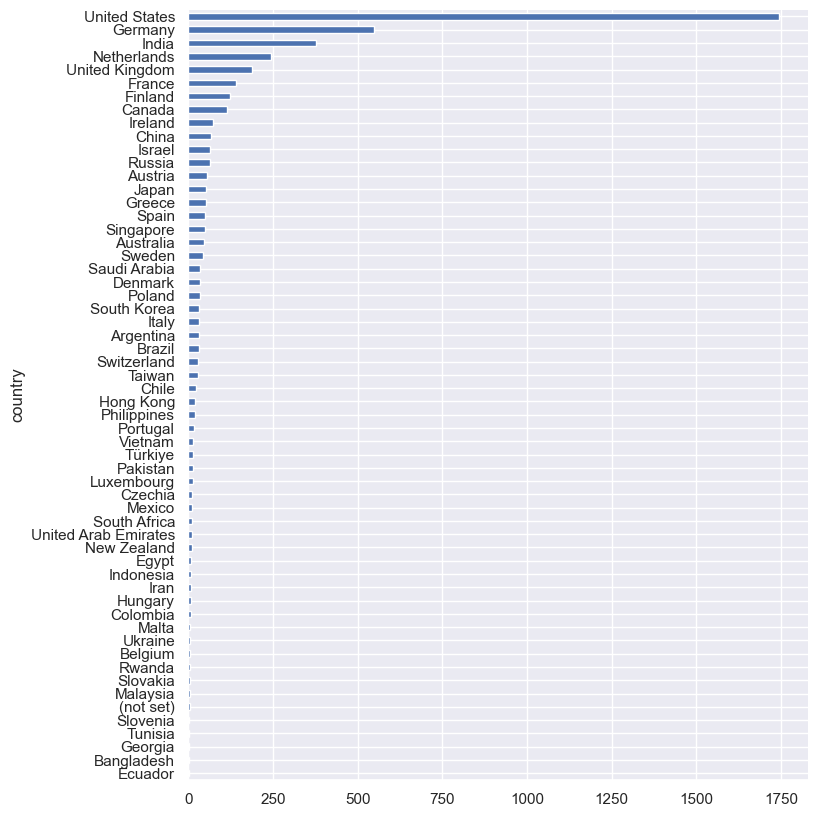

In [18]:
df.groupby('country').sessions.sum().sort_values(ascending=True).plot(kind='barh', figsize=(8, 10))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

In [19]:
page_view_df = df[df.eventName == 'page_view']

<Axes: ylabel='browser'>

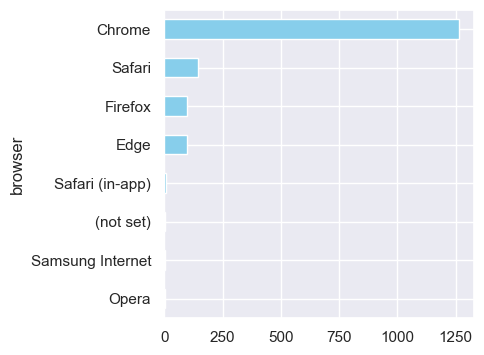

In [20]:
page_view_df.groupby([
    # 'deviceCategory',
    # 'city',
    # 'region',
    # 'country',
    'browser',
]).sessions.count().sort_values(ascending=True).plot(kind='barh', figsize=(4, 4), color='skyblue')